In [1]:
%load_ext autoreload
%autoreload 2
%autosave 2


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from tqdm.notebook import tqdm
import numpy as np
from fastai.text import *
from modules.callbacks import *
from pathlib2 import Path
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from fastai.callbacks import lr_finder, SaveModelCallback, EarlyStoppingCallback,ReduceLROnPlateauCallback
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
from modules.model import *

defaults.device = torch.device('cuda')
#CUDA_VISIBLE_DEVICES=""
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 2 seconds


cuda


In [2]:
## Writing processed data into pickle file

#pickle.dump(qs, open('fr-2-en-data/fr-en-qs.pkl','wb'))
qs = pickle.load(open('fr-2-en-data/fr-en-qs.pkl','rb'))

en_qs,fr_qs = zip(*qs)

In [3]:
path = Path()

In [4]:
en_tok = pickle.load((path/'fr-2-en-data/en_tok.pkl').open('rb'))
fr_tok = pickle.load((path/'fr-2-en-data/fr_tok.pkl').open('rb'))

In [5]:
TMP_PATH = path/'fr-2-en-data/tmp/'

def load_ids(pre):
    ids = np.load(TMP_PATH/f'{pre}_ids.npy',allow_pickle=True)
    itos = pickle.load(open(TMP_PATH/f'{pre}_itos.pkl', 'rb'))
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    return ids,itos,stoi

In [6]:
en_ids,en_itos,en_stoi = load_ids('en')
fr_ids,fr_itos,fr_stoi = load_ids('fr')

## Fastai's Data Bunch

In [7]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    
    # unpack samples to tuples
    samples = to_data(samples)
    
    # find max len of x, y batch wihich decides inp seq length
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    
    max_len = max(max_len_x,max_len_y)
    
    # create a dummy tensor of height batch_size and width max_len with padded value
    res_x = torch.zeros(len(samples), max_len).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len).long() + pad_idx
    
    # if backwards activate reverse mode used in bi-directional   
    if backwards: pad_first = not pad_first
    
    # fill vocabulary indices
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i, :len(s[0])],res_y[i, :len(s[1])] = LongTensor(s[0]),LongTensor(s[1])
    
    # flip backward if backwards = True
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
        
    res_x_mask = (res_x != pad_idx).unsqueeze(-2)
    res_y_mask = None
    
    # target mask creation
    if res_y is not None:
        dec_y = res_y[:, :-1]
        tar_y = res_y[:, 1:]
        decode_lengths = torch.tensor([len(s[1]) for s in samples])-1
    return (res_x[:,1:],dec_y,decode_lengths), tar_y

In [8]:
class Seq2SeqDataBunch(TextDataBunch):
    " decorator adds following method additionally to base class 'TextDataBunch"
    
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=8, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=device, no_check=True, backwards:bool=False, **dl_kwargs)-> DataBunch:
        
        "Function takes pytorch dataset object transforms into 'databunch' for classification and cls will allow to access parent class methods just  like 'self'"
        
        # store dataset obj into list
        datasets = cls._init_ds(train_ds,valid_ds,test_ds)
        val_bs = ifnone(val_bs, bs) #returns val_bs if none bs
        
        # stores raw seq of unequal len into tensor with padding
        # below function takes batches output from Dataloader returns padded tensor
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        
        #sampler function: generater takes dataset then sorts and returns sorted indices    
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        
        # train data loader obj with Sortish sampler(sort with some randomness)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        
        # other dataloaders with pure sorting append into dataloaders list
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key = lengths.__getitem__)
            dataloaders.append(DataLoader(ds,batch_size=val_bs,
                                          sampler = sampler,**dl_kwargs))
        
        return cls(*dataloaders, path = path, device = device, collate_fn=collate_fn, no_check = no_check)

In [9]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.width', 10000)
pd.set_option('display.expand_frame_repr', True)


data = pd.DataFrame(qs, columns=['en', 'fr'])

In [48]:
data.sample(5)[['fr', 'en']].style.set_properties(subset=['fr', 'en'], **{'width': '300px'})

,fr,en
7957,En quoi consiste une inspection d'un agent des pêches?,What happens if I'm inspected by a fishery officer?
23052,Quels sont les avantages et les inconvénients du système de La Haye pour un utilisateur tel que vous?,What are the pluses/minuses of the Hague system for you as an individual user?
34628,À qui ces activités douteuses profitent-elles?,Who profits from this dubious activity?
29141,Quelles sont les forces et faiblesses du programme de la PNE et des activités qui y sont associées?,What are the strengths and weaknesses of the NCB Program and its activities?
22353,• Que fait l'OMPI en plus de traiter les affaires soumises en application des principes UDRP?,What is WIPO doing in addition to administering cases under the UDRP?


In [29]:
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

In [11]:
# lowercase
data['en'] = data['en'].apply(lambda x:x.lower())
data['fr'] = data['fr'].apply(lambda x:x.lower())

### create a Seq2SeqTextList (Fastai's datablock api)

In [12]:
# text list with 'fr' column as label  and split list randomly (0.8) 
src = (Seq2SeqTextList.from_df(data, path = path, cols='fr')
       .split_by_rand_pct(seed=42)
       .label_from_df(cols='en',label_cls=TextList))

In [13]:
src = src.filter_by_func(lambda x,y: len(x) > 30 or len(y) > 30)

In [120]:
from modules.model import *
from modules.callbacks import *
from transformer.model import Translation

en_emb = torch.load('models/en_emb.pth')
fr_emb = torch.load('models/fr_emb.pth')

databunch = src.databunch()
databunch.batch_size = 64

'''
(Pdb) dec_input
['[SOS]', 'Bible', 'Color', '##ing', "'", 'is', 'a', 'coloring', 'application', 'that', 'allows', 'you', 'to', 
'experience', 'beautiful', 'stories', 'in', 'the', 'Bible', '.', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 
'[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 
'[PAD]', '[PAD]', '[PAD]', '[PAD]']

(Pdb) dec_output
['Bible', 'Color', '##ing', "'", 'is', 'a', 'coloring', 'application', 'that', 'allows', 'you', 'to', 
'experience', 'beautiful', 'stories', 'in', 'the', 'Bible', '.', '[EOS]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 
'[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 
'[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']

-> dec_inputs.append(dec_input)

(Pdb) dec_input
[1, 5907, 13068, 1160, 114, 1112, 172, 25889, 4050, 1117, 3645, 1130, 1108, 2543, 2714, 2803, 1109, 1105, 
5907, 121, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

(Pdb) dec_output
[5907, 13068, 1160, 114, 1112, 172, 25889, 4050, 1117, 3645, 1130, 1108, 2543, 2714, 2803, 1109, 1105, 
5907, 121, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
'''



'''{'kor_vocab_length': 50000,
 'eng_vocab_length': 28998,
 'd_model': 768,
 'd_ff': 2048,
 'd_k': 64,
 'd_v': 64,
 'num_layers': 12,
 'num_heads': 8,
 'start_word': '[SOS]', #xxbos
 'end_word': '[EOS]',
 'sep_word': '[SEP]',
 'cls_word': '[CLS]',
 'pad_word': '[PAD]', #xxpad
 'mask_word': '[MASK]'} #xxpad 0'''

'''model = Translation(src_vocab_size=len(fr_stoi),
    tgt_vocab_size=len(en_stoi),
    d_model=300, d_ff=2048,
    d_k=64, d_v=64, n_heads=6, 
    n_layers=6, src_pad_index=src_pad_index,
    tgt_pad_index=src_pad_index, device=device)'''

#model = make_model(len(fr_stoi), len(en_stoi), N=6, h = 6, d_model=300,src_embedding = None,tar_embedding = None).to(device);
model = Translation(src_vocab_size=len(fr_stoi),
    tgt_vocab_size=len(en_stoi),
    d_model=300, d_ff=2048,
    d_k=64, d_v=64, n_heads=6, 
    n_layers=6, src_pad_index=1,
    tgt_pad_index=1, device=device)


In [16]:
dict(src_vocab_size=len(fr_stoi),
    tgt_vocab_size=len(en_stoi),
    d_model=300, d_ff=2048,
    d_k=64, d_v=64, n_heads=6, 
    n_layers=6, src_pad_index=1,
    tgt_pad_index=1, device=device)

### Fastai - with CrossEntropyLoss

In [15]:
def CrossEntropy_loss(input,targets):
    pred,_,_,_,decode_lengths = input
    x,y = pred.contiguous().view(-1, pred.size(-1)), targets.contiguous().view(-1)
    loss = nn.CrossEntropyLoss().to(device)(F.log_softmax(x, dim=-1), y)
    return  loss #loss(pred.data.long(), targets.data.long())


In [27]:
from modules.callbacks import *
opt_fn = partial(optim.Adam, betas=(0.9, 0.98))

#criterion = LabelSmoothing(len(en_itos), 1, 0.1).to(device)

#learn = Learner(dataBunch,arch,loss_func= loss_func,opt_func=opt_fn, metrics=[topK_accuracy,BleuMetric(metadata,vocab)],callback_fns=[ShowGraph]) #,TeacherForcingTurnOff,TeacherForcingCallback



learn_CEL = Learner(databunch,model,loss_func=CrossEntropy_loss,wd=0.1, metrics=[seq2seq_acc, CorpusBLEU(len(en_itos))],callback_fns=[ShowGraph]) #,TeacherForcingTurnOff,TeacherForcingCallbacklearn = 

epoch,train_loss,valid_loss,seq2seq_acc,bleu_metric,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-05
Min loss divided by 10: 1.20E-02


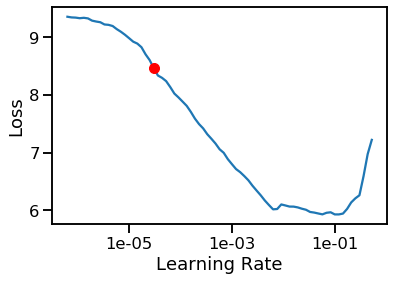

In [19]:
learn_CEL.lr_find()
learn_CEL.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,2.456067,2.653436,0.612640,0.433706,01:28
1,2.041358,2.261911,0.642574,0.462979,01:28
2,1.675195,1.926699,0.680742,0.488075,01:28
3,1.384582,1.713956,0.702641,0.511958,01:31
4,1.127888,1.588813,0.723198,0.536749,01:33
5,0.813250,1.529009,0.734520,0.553977,01:37
6,0.497641,1.541128,0.743082,0.570197,01:32
7,0.262595,1.580004,0.747232,0.581183,01:31
8,0.140268,1.620333,0.750187,0.587652,01:31
9,0.086930,1.639049,0.750771,0.589219,01:32


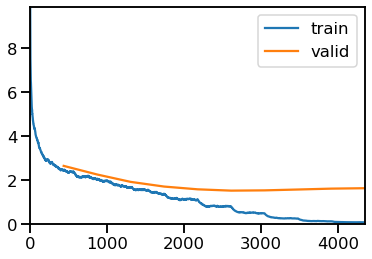

In [28]:
learn_CEL.fit_one_cycle(10, 5e-4, div_factor=5)

In [34]:
%debug

> /home/skumar/miniconda3/envs/ImageCaption/lib/python3.7/site-packages/nltk/translate/bleu_score.py(324)modified_precision()
    322     for reference in references:
    323         reference_counts = (
--> 324             Counter(ngrams(reference, n)) if len(reference) >= n else Counter()
    325         )
    326         for ngram in counts:

ipdb> type(references)
<class 'list'>
ipdb> len(references)
26
ipdb> references
[11, 16, 10, 1954, 17, 41, 19, 10, 49, 662, 27, 3476, 663, 12, 152, 13, 538, 13, 10, 476, 510, 12, 578, 2652, 94, 9]
ipdb> exit


In [18]:
learn_CEL.export()

In [29]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(*xb)[0]
            for x,y,z in zip(xb[0],yb,out):
                inputs.append(learn.data.train_ds.x.reconstruct(x.cpu()))
                targets.append(learn.data.train_ds.y.reconstruct(y.cpu()))
                outputs.append(learn.data.train_ds.y.reconstruct(z.cpu().argmax(1)))
    return inputs, targets, outputs

In [30]:
inputs, targets, outputs = get_predictions(learn_CEL)

In [31]:
inputs[500],targets[500],outputs[500]

(Text si on parle des gens en xxunk , xxunk que la dynamique de travail et xxunk est différente de celle d’une installation permanente ?,
 Text when it comes to the people on tour , i xxunk that the xxunk dynamic is different from what goes on in a permanent production ?,
 Text whether the comes to the people , xxunk , are and and the work work and different from a a ? a a food resident ?)

In [32]:
inputs[22],targets[22],outputs[22]

(Text quels sont les prix de vente en gros et au détail que vous prévoyez demander pour votre ( vos ) xxunk ) ou produit xxunk contenant notre matériel ?,
 Text what will be your anticipated xxunk and retail price for each of your xxunk ) or any work derived from using our material ?,
 Text what are xxunk the price price and selling about xxunk your of your product and that product material ? from your for product ?)

### Fastai - with LabelSmoothingLoss

In [121]:
class SmoothLabelCritierion(nn.Module):
    """
    TODO:
    1. Add label smoothing
    2. Calculate loss
    """

    def __init__(self, label_smoothing=0.0):
        super(SmoothLabelCritierion, self).__init__()
        self.label_smoothing = label_smoothing
        self.LogSoftmax = nn.LogSoftmax()

        # When label smoothing is turned on, KL-divergence is minimized
        # If label smoothing value is set to zero, the loss
        # is equivalent to NLLLoss or CrossEntropyLoss.
        if label_smoothing > 0:
            self.criterion = nn.KLDivLoss(reduction='batchmean')
        else:
            self.criterion = nn.NLLLoss()
        self.confidence = 1.0 - label_smoothing

    def _smooth_label(self, num_tokens):

        one_hot = torch.randn(1, num_tokens)
        one_hot.fill_(self.label_smoothing / (num_tokens - 1))
        return one_hot

    def _bottle(self, v):
        return v.view(-1, v.size(2))

    def forward(self, dec_outs, labels):
        # Map the output to (0, 1)
        dec_outs = dec_outs[0]
        scores = self.LogSoftmax(dec_outs)
        # n_class
        num_tokens = scores.size(-1)

        gtruth = labels.view(-1)
        if self.confidence < 1:
            tdata = gtruth.detach()
            one_hot = self._smooth_label(num_tokens)
            if labels.is_cuda:
                one_hot = one_hot.cuda()
            tmp_ = one_hot.repeat(gtruth.size(0), 1)
            tmp_.scatter_(1, tdata.unsqueeze(1), self.confidence)
            gtruth = tmp_.detach()
        loss = self.criterion(scores.view(-1, scores.size(-1)), gtruth)
        return loss
    
    
def LabelSmoothingCrossEntropy_func(input,targets):
    x,y = input,targets
    loss = SmoothLabelCritierion(label_smoothing=0.1).to(device)(x,y)
    return loss

In [105]:
opt_fn = partial(optim.Adam, betas=(0.9, 0.98))

criterion = LabelSmoothing(len(en_itos), 1, 0.1).to(device)

learn_LSL = Learner(databunch,model,loss_func=LabelSmoothingCrossEntropy_func,wd=0.1, metrics=[seq2seq_acc, CorpusBLEU(len(en_itos))],callback_fns=[ShowGraph]) #,TeacherForcingTurnOff,TeacherForcingCallbacklearn = 

/home/skumar/miniconda3/envs/ImageCaption/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch,train_loss,valid_loss,seq2seq_acc,bleu,time


/home/skumar/miniconda3/envs/ImageCaption/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-03
Min loss divided by 10: 3.02E-04


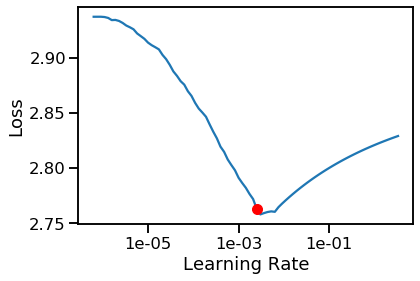

In [21]:
learn_LSL.lr_find()
learn_LSL.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,2.141443,2.071022,0.567044,0.400781,01:35
1,1.898499,1.855029,0.565619,0.399401,01:35
2,1.753499,1.721894,0.570702,0.409064,01:38
3,1.610226,1.642993,0.572891,0.405655,01:39
4,1.497186,1.608099,0.599936,0.430033,01:36
5,1.357414,1.595815,0.614662,0.440933,01:36
6,1.260690,1.604014,0.640098,0.473974,01:35
7,1.187641,1.621607,0.664208,0.498927,01:36
8,1.166813,1.645855,0.676659,0.511069,01:35
9,1.142947,1.658493,0.679379,0.513981,01:35


/home/skumar/miniconda3/envs/ImageCaption/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


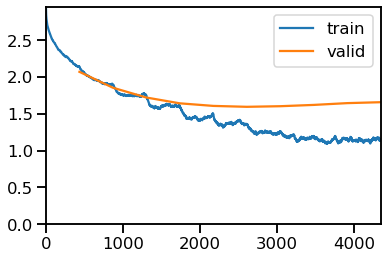

Better model found at epoch 0 with valid_loss value: 2.071021556854248.


/home/skumar/miniconda3/envs/ImageCaption/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Better model found at epoch 1 with valid_loss value: 1.855028748512268.


/home/skumar/miniconda3/envs/ImageCaption/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Better model found at epoch 2 with valid_loss value: 1.7218936681747437.


/home/skumar/miniconda3/envs/ImageCaption/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Better model found at epoch 3 with valid_loss value: 1.6429928541183472.


/home/skumar/miniconda3/envs/ImageCaption/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Better model found at epoch 4 with valid_loss value: 1.608099102973938.


/home/skumar/miniconda3/envs/ImageCaption/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Better model found at epoch 5 with valid_loss value: 1.5958151817321777.


/home/skumar/miniconda3/envs/ImageCaption/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/skumar/miniconda3/envs/ImageCaption/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/skumar/miniconda3/envs/ImageCaption/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/skumar/miniconda3/envs/ImageCaption/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [106]:
from torch.utils.tensorboard import SummaryWriter
from fastai.callbacks.TensorBoardCallback import *
from fastai.callbacks import lr_finder, SaveModelCallback


writer = SummaryWriter(comment='stage1')
tb_callback = partial(TensorBoardFastAI, writer, 
                      track_weight=True, track_grad=True, 
                      metric_names=['val loss','accuracy','bleu_metric']) #beam_search_bleu4




learn_LSL.fit_one_cycle(10, 5e-4, div_factor=5,callbacks = [SaveModelCallback(learn_LSL, monitor='valid_loss',name='bestmodel'),
                                                            tb_callback(learn_LSL)])

In [58]:
learn_LSL.load('bestmodel');
#learn_LSL.export('Label_smoothing_trnsformer.pkl')

In [115]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(*xb)[0]
            for x,y,z in zip(xb[0],yb,out):
                inputs.append(learn.data.train_ds.x.reconstruct(x.cpu()))
                targets.append(learn.data.train_ds.y.reconstruct(y.cpu()))
                outputs.append(learn.data.train_ds.y.reconstruct(z.cpu().argmax(1)))
    return inputs, targets, outputs

In [116]:
inputs, targets, outputs = get_predictions(learn_LSL)

In [117]:
inputs[500],targets[500],outputs[500]

(Text si on parle des gens en xxunk , xxunk que la dynamique de travail et xxunk est différente de celle d’une installation permanente ?,
 Text when it comes to the people on tour , i xxunk that the xxunk dynamic is different from what goes on in a permanent production ?,
 Text when people comes to people people , people , if think , there workplace of is no than any they into a one permanent one of)

In [29]:
!shutdown -h 10

Shutdown scheduled for Tue 2020-06-23 00:21:22 IST, use 'shutdown -c' to cancel.


In [118]:
inputs[22],targets[22],outputs[22]

(Text quels sont les prix de vente en gros et au détail que vous prévoyez demander pour votre ( vos ) xxunk ) ou produit xxunk contenant notre matériel ?,
 Text what will be your anticipated xxunk and retail price for each of your xxunk ) or any work derived from using our material ?,
 Text which price be the organization rate price you development would you product your product ( or your technical ( ( your your product ()

In [119]:
inputs[0],targets[0],outputs[0]

(Text quelles sont les possibilités qui s’offrent au canada au modèle de coopérative de santé comme organisme susceptible de contribuer à la prestation fructueuse des services de santé primaires ?,
 Text what are the possibilities in canada for the health co - operative model of organization to contribute to the successful delivery of primary healthcare services ?,
 Text which possibilities canada opportunities for canada ’s health model care - organization health of health as achieve to health primary services of health health services offered)

### Model Deplotment

In [122]:
learn_LSL.model.eval()
text = "qu'est-ce que le gouvernement responsable?"
enc_inp = torch.tensor(databunch.x.process_one(text)).unsqueeze(0)
dec_out = [2]
dec_len = torch.tensor([50])

while len(dec_out) < 50:
    dec_input = torch.as_tensor([dec_out], dtype=torch.long)
    enc_inp,dec_input,dec_len=[i.to('cuda') for i in (enc_inp,dec_input,dec_len)]
    with torch.no_grad():
        out = learn_LSL.model(enc_inp[:,1:],dec_input,dec_len)
    predict = out[0].squeeze(0).argmax(1)[-1].detach().cpu().numpy()
    dec_out.append(int(predict))

In [123]:
learn_LSL.data.train_ds.y.reconstruct(torch.as_tensor([dec_out], dtype=torch.long)[0])

Text xxbos where is government ?

In [102]:
torch.as_tensor([dec_out], dtype=torch.long)

tensor([[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]])

In [77]:
out[0].squeeze(0).argmax(1)
out_text = learn.data.train_ds.y.reconstruct(out[0].squeeze(0).argmax(1))

TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [124]:
inputs[21], targets[21], outputs[21]

(Text quelles sont les priorités relatives des différents projets , existe - il une relation xxunk , et ces priorités doivent - elles toutes être incluses dans le xxunk ?,
 Text what are the relative priorities of the various projects , is there a xxunk relationship , and should they all be included in the xxunk ?,
 Text which priorities the priorities projects that projects projects projects , including needed any priorities , between and what be be these included in regard relationship ))